# 영화 추천 시스템

추천시스템의 MNIST라고 불리는 Movielens 데이터를 사용해서 영화추천을 구현한다.

**필요 라이브러리 불러오기**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

**데이터 읽기**

In [2]:
base_path='data/movie/'

ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(base_path + 'ratings.dat', sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")

movies_cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(base_path + 'movies.dat', sep='::', names=movies_cols, engine='python', encoding='ISO-8859-1')

In [3]:
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


<br/><br/>

### **Movies 데이터 탐색**

**movies 파일은 id 값과 해당되는 영화제목(title)을 알려주고 어떠한 장르(genre)인지 알려준다**

장르는 영화에서 엄청 중요한 정보이다. 하지만 위의 `timestamp`와 같은 이유로 반영하지 않는다.<br/>
영화 제목을 모두 소문자로 바꾸고 `idx_to_title`을 추출하자.

In [4]:
movies['title'] = movies['title'].str.lower()

idx_to_title = pd.Series(movies['title'].values, index=movies['movie_id']).to_dict()
title_to_idx = {v: i for i, v in idx_to_title.items()}

Movies 데이터에서 사용하는 데이터는 `idx_to_title`이다. 하지만 이 데이터가 ratings의 영화들을 모두 커버할 수 있는지는 확인이 필요하다.

In [5]:
# 한개라도 커버할 수 없는 영화가 있다면 에러 발생
assert False == any([i not in idx_to_title.keys() for i in ratings['movie_id'].unique()]), "포함되지 않는 제목이 있다."

<br/><br/>

### **Ratings 데이터 탐색**

**ratings 파일은 유저(user_id)가 영화(movie_id)에 대한 평점(rating)을 언제(timestamp) 매겼는지에 대한 정보를 보여준다.**

**timestamp 컬럼 제거**

`timestamp`는 사용자가 평점을 메긴 시간에 대한 데이터로 데이터 분석에 꽤 중요할 수 있지만 우리의 모델에서 일단 활용하지 않는다. 제거하자.

In [6]:
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


**Ratings** 분포 확인하기

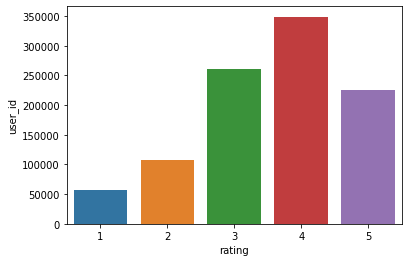

In [7]:
ratings_cnt = ratings.groupby('rating').count()
_ = sns.barplot(x=ratings_cnt.index, y="user_id", data=ratings_cnt)

**3점이 넘는 데이터더만 추출하기**

평점은 좋고 나쁨을 표현할 수 있는 데이터지만 우리는 저금 더 단순하게 문제를 해결하기 위해 `좋다`라는 키워드를 통해 사용자의 선호 영화를 분석하고 그에 따라 추천 시스템을 구현하고자 한다.(4 이상의 점수만 남긴다면 어떻게 추천이 될지도 생각해보자)

In [8]:
origin_data_size = ratings.shape[0]

ratings = ratings[ratings['rating']>=3]
filtered_data_size = ratings.shape[0]

print(f'orginal_data_size: {origin_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / origin_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


<br/>**전체 유저 수**

In [9]:
f"전체 유저 수 : {ratings['user_id'].nunique()}"

'전체 유저 수 : 6039'

<br/>**전체 영화 수**

In [10]:
f"전체 영화 수 : {ratings['movie_id'].nunique()}".strip()

'전체 영화 수 : 3628'

<br/>**유저별 몇개의 영화를 좋아하는지 확인**

"좋아하는지" 라고 적은 이유는 3점 이상의 리뷰만을 추출한 데이터로 분석을 하기 때문이다.

유저 별 좋아하는 영화 수 : 
count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64


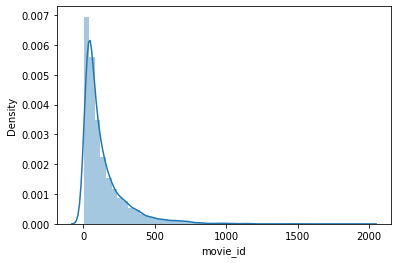

In [11]:
user_count = ratings.groupby('user_id')['movie_id'].count()
print("유저 별 좋아하는 영화 수 : \n{}".format(user_count.describe()))
_ = sns.distplot(user_count)

<br/>**유저별 평점 평균 확인**

평점은 굉장히 주관적인 데이터다보니 사람의 성향에 따라 평균값이 크게 다를 듯하다.<br/>
하지만 우리는 3점 이상의 점수만을 추출했다는 점을 유의해야한다.

유저 별 평점 평균 : 
count    6039.000000
mean        4.025078
std         0.275632
min         3.000000
25%         3.833333
50%         4.023622
75%         4.212225
max         5.000000
Name: rating, dtype: float64


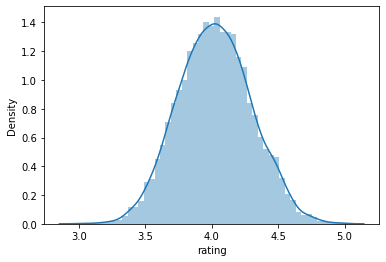

In [12]:
user_rating_mean = ratings.groupby('user_id')['rating'].mean()
print("유저 별 평점 평균 : \n{}".format(user_rating_mean.describe()))
_ = sns.distplot(user_rating_mean)

<br/>**가장 인기있는 영화 순위**

순위는 각 영화의 평점을 다 더하면 손쉽게 구할 수 있다.

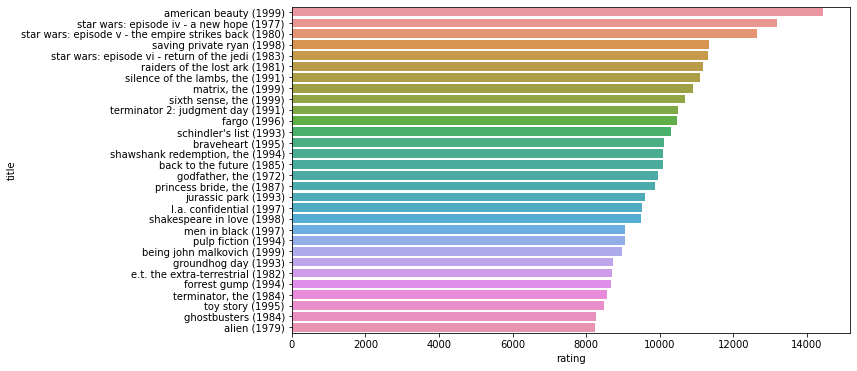

In [13]:
plt.figure(figsize=(10, 6))
ranking = pd.DataFrame(ratings.groupby('movie_id')['rating'].sum().sort_values(ascending=False)[:30])
ranking['title'] = ranking.index.map(idx_to_title)
_ = sns.barplot(y='title',x='rating', data=ranking)

<br/>**나의 데이터 추가하기**

내가 좋아하는 영화의 평점을 5개 매겨보자.

In [14]:
my_favorite = {
    "titanic (1997)": 5,
    "toy story (1995)": 3,
    "leaving las vegas (1995)": 5,
    "before sunrise (1995)": 4,
    "when night is falling (1995)": 4
}

my_favorite_index = {title_to_idx[title]: rating for title, rating in my_favorite.items()}
my_favorite_index

{1721: 5, 1: 3, 25: 5, 215: 4, 49: 4}

In [15]:
user_id = ratings['user_id'].max() + 1
cnt = len(my_favorite_index)

my_df = pd.DataFrame({"user_id": [user_id]*cnt, "movie_id": my_favorite_index.keys(), "rating": my_favorite_index.values()})

ratings = ratings.append(my_df).reset_index()
ratings

,index,user_id,movie_id,rating
0,0,1,1193,5
1,1,1,661,3
2,2,1,914,3
3,3,1,3408,4
4,4,1,2355,5
...,...,...,...,...
836478,0,6041,1721,5
836479,1,6041,1,3
836480,2,6041,25,5
836481,3,6041,215,4


## CSR MATRIX

**SHAPE 설정**

바로 위의 ratings를 언듯보면 1~6041까지의 데이터가 있구나 6041개의 데이터가 있겠구나 라고 생각이 들 수 있다. 하지만 상세히 확인해보면 한개가 `3598`의 user_id는 존재하지 않는다. 마찬가지로 movie_id에도 Min, Max 사이에 결측값이 있다. 그래서 CSR_MATRIX를 만들 때 주의해야한다. 

- Row에서 가장 큰 값 + 1
- Column에서 가장 큰 값 + 1

이렇게 설정해주면 문제가 없다. 

`+1`을 하는 이유는 csr_matrix를 만들때 기본적으로 Index가 0부터 시작하기 때문이다. 학습 이후에 csr_matrix를 조회하면 모든 값이 0이 나온것을 확인할 수 있다.

**하지만 아무런 값을 넣어주지 않아도 적절한 크기로 배열을 생성한다.**

In [16]:
from scipy.sparse import csr_matrix

max_user = ratings['user_id'].max()
max_movie = ratings['movie_id'].max()

csr_data = csr_matrix((ratings.rating, (ratings.user_id, ratings.movie_id)), shape=(max_user+1, max_movie+1))

# 아무런 값을 넣지 않아도 잘 동작한다.
# csr_data = csr_matrix((ratings.rating, (ratings.user_id, ratings.movie_id))) # 

## 모델 설계 및 학습

In [17]:
from implicit.als import AlternatingLeastSquares

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [18]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=128, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [19]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose.shape

(3953, 6042)

In [20]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

<br/>

## 평가하기

In [21]:
def recommend_score(movie):
    movie_idx = title_to_idx[movie]
    suwan_vector, movie_vector = als_model.user_factors[user_id], als_model.item_factors[movie_idx]
    score = np.dot(suwan_vector, movie_vector)

    print(f"나의 {movie} 선호도 예측 : {score:.3}")

<br/>**내가 좋아하는 영화의 선호도 확인하기**

In [22]:
movie = 'titanic (1997)'
recommend_score(movie)

나의 titanic (1997) 선호도 예측 : 0.608


<br/>**다른 영화의 선호도 확인하기**

In [23]:
movie = 'toy story (1995)'
recommend_score(movie)

나의 toy story (1995) 선호도 예측 : 0.318


In [24]:
movie = 'tigerland (2000)'
recommend_score(movie)

나의 tigerland (2000) 선호도 예측 : -0.00934


<br/>**비슷한 영화 추천받기**

In [25]:
movie = 'titanic (1997)'
movie_idx = title_to_idx[movie]
recommends = als_model.similar_items(movie_idx)[1:] # 자신과의 유사도는 1이다. 제외
print(f"{movie}를 좋아하는 사람에게 추천하는 영화 순위\n")
for i, rec in enumerate(recommends):
    title = idx_to_title[rec[0]]
    score = rec[1]
    print(f"{i+1}.{title}\n   score : {score:.3}")

titanic (1997)를 좋아하는 사람에게 추천하는 영화 순위

1.jerry maguire (1996)
   score : 0.463
2.city of angels (1998)
   score : 0.363
3.you've got mail (1998)
   score : 0.351
4.mr. holland's opus (1995)
   score : 0.345
5.ever after: a cinderella story (1998)
   score : 0.34
6.truman show, the (1998)
   score : 0.326
7.snow day (2000)
   score : 0.319
8.fried green tomatoes (1991)
   score : 0.318
9.piano, the (1993)
   score : 0.308


<br/>**내가 좋아할 만한 영화 추천 받기**

In [26]:
recommends = als_model.recommend(user_id, csr_data, N=10, filter_already_liked_items=True)
for i, rec in enumerate(recommends):
    title = idx_to_title[rec[0]]
    score = rec[1]
    print(f"{i+1}.{title}\n   score : {score:.3}")

1.jerry maguire (1996)
   score : 0.305
2.gone with the wind (1939)
   score : 0.239
3.english patient, the (1996)
   score : 0.227
4.piano, the (1993)
   score : 0.202
5.like water for chocolate (como agua para chocolate) (1992)
   score : 0.195
6.thelma & louise (1991)
   score : 0.173
7.babe (1995)
   score : 0.169
8.shakespeare in love (1998)
   score : 0.169
9.good will hunting (1997)
   score : 0.167
10.toy story 2 (1999)
   score : 0.165


<br/>

## 고찰

추천시스템이라는 분야는 너무 어렵고 멀게만 느껴졌었다. 이번 노드를 통해 추천시스템 모델에 대해 깊게 배운것은 아니지만 조금 벽을 허물 수 있었다.<br/>
그리고 이번에 사용하지 못했던 리뷰를 작성한 날짜 데이터, 영화의 장르 데이터에 대한 아쉬움이 있다. 아쉬움 덕분에 더 호기심이 생겼고 재밌었다.